In [1]:
import tempfile

import requests
import rasterio
import rasterio.windows
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

In [2]:
run = 'bbwduc-ERD2018-EBIRD_SCIENCE-20191105-dc3957b5'
example_url = f'https://s3-us-west-2.amazonaws.com/ebirdst-data/{run}/results/tifs/{run}_hr_2018_occurrence_median.tif'
folder = tempfile.TemporaryDirectory()
with open(folder.name + '/example.tif', 'wb') as f:
    f.write(requests.get(example_url).content)

In [3]:
dataset = rasterio.open(folder.name + '/example.tif')

In [4]:
print(dataset.count, dataset.height, dataset.width)

52 5630 7074


In [5]:
def show(array):
    f, ax = plt.subplots(1, figsize=(10, 7))
    ax.matshow(array);
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_color('grey')
    return ax

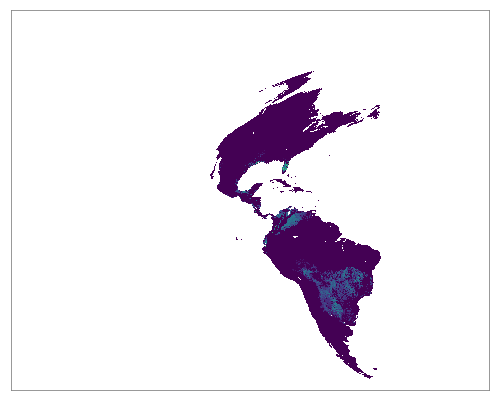

In [6]:
show(dataset.read(1));

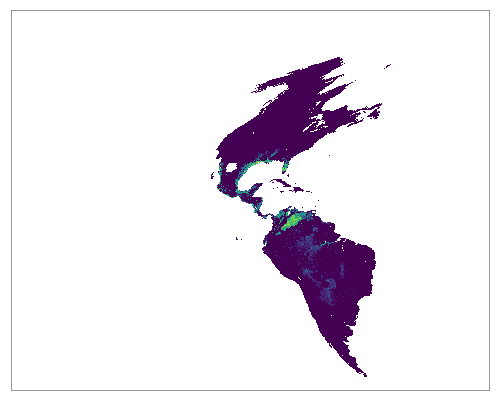

In [7]:
show(dataset.read(26));

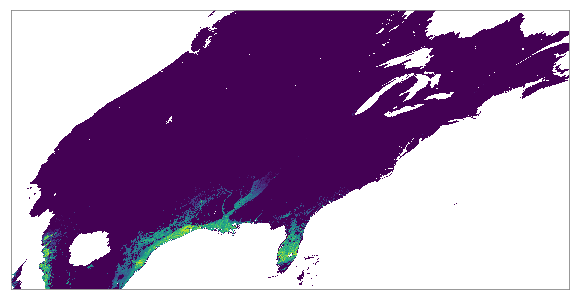

In [8]:
window = rasterio.windows.Window(2950, 1400, 2200, 1100)
show(dataset.read(26, window=window));

In [9]:
x = dataset.read(window=window)
x.shape

(52, 1100, 2200)

In [10]:
kwargs = dataset.meta.copy()
kwargs.update({
    'height': window.height,
    'width': window.width,
    'transform': rasterio.windows.transform(window, dataset.transform),
    'compress': 'deflate'})

with rasterio.open(folder.name + '/smallex.tif', 'w', **kwargs) as new_dataset:
    new_dataset.write(dataset.read(window=window))
dataset2 = rasterio.open(folder.name + '/smallex.tif')

In [11]:
kwargs = dataset.meta.copy()
kwargs.update({
    'height': window.height,
    'width': window.width,
    'transform': rasterio.windows.transform(window, dataset.transform),
    'compress': 'deflate',
    'dtype': 'uint8'})

with rasterio.open(folder.name + '/tiny_ex.tif', 'w', **kwargs) as new_dataset:
    new_dataset.write((dataset.read(window=window) * 255).astype(np.uint8))
dataset3 = rasterio.open(folder.name + '/tiny_ex.tif')

In [12]:
from pathlib import Path
[(f, f.stat().st_size / 10**9) for f in Path(folder.name).glob('*')]

[(PosixPath('/tmp/tmp87om50og/tiny_ex.tif'), 0.002270485),
 (PosixPath('/tmp/tmp87om50og/example.tif'), 0.106236129),
 (PosixPath('/tmp/tmp87om50og/smallex.tif'), 0.008511119)]

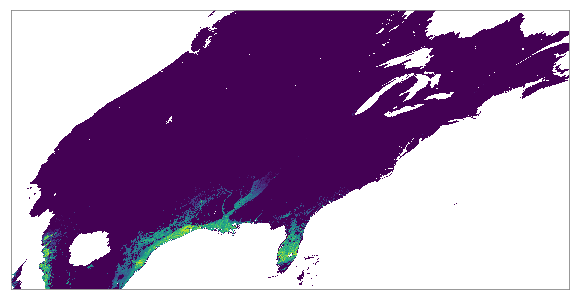

In [13]:
show(dataset2.read(26));

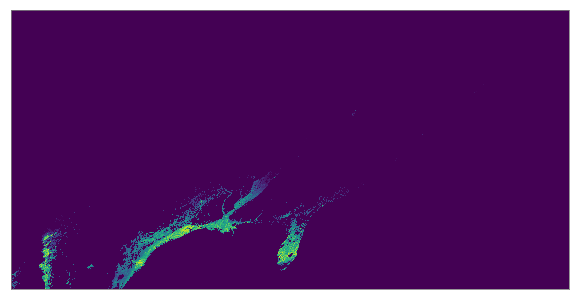

In [14]:
# Since this is uint8, there's no nan/-inf to use, so it gets put to 0.
show(dataset3.read(26));

In [15]:
# transformer from lat/long to dataset coordinates
# use always_xy to make it long/lat
transformer = Transformer.from_crs("EPSG:4326", dataset2.crs)

In [16]:
transformer.transform(41.6, -80)

(-6652115.803282049, 4625714.162228736)

In [17]:
# Check some extreme points for IndexErrors
print(dataset2.read(26)[dataset2.index(*transformer.transform(26.87, -80.3))])
print(dataset2.read(26)[dataset2.index(*transformer.transform(47.306303, -72.182394))])
print(dataset2.read(26)[dataset2.index(*transformer.transform(49.768897, -66.736356))])
print(dataset2.read(26)[dataset2.index(*transformer.transform(48.966602, -95.318046))])

0.42467734
0.0
-inf
0.0
